<a href="https://colab.research.google.com/github/vikkkkos/-ecg/blob/main/ecg_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Подключение к GoogleDisc**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install wfdb
!pip install PyWavelets

# **Импорт библиотек**

In [ ]:
import pandas as pd
import numpy as np
# import wfdb
import ast

from sklearn.model_selection import train_test_split
import pywt
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, MaxPool1D, \
                         Dropout, GlobalAvgPool1D, Dense, Softmax
from keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

# **Загрузка данных**

In [ ]:
path = '/content/drive/MyDrive/dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [ ]:
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
y_binary = Y['diagnostic_superclass'].apply(
    lambda x: np.isin(classes, x).astype(int).tolist()
)
Y['diagnostic_superclass'] = y_binary
y_filtered = Y[Y['diagnostic_superclass'].apply(sum) == 1]

In [ ]:
# CLASS_NAMES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
# y_binary_1 = np.stack(y_filtered.diagnostic_superclass)
# y_number_classes = np.argmax(y_binary_1, axis=1)

# class_counts = {}
# for i, name in enumerate(CLASS_NAMES):
#     count = np.sum(y_number_classes == i)
#     class_counts[name] = count

# print("Распределение классов:")
# for name, count in class_counts.items():
#       print(f"{name}: {count}")

In [ ]:
# def load_raw_data(df, sampling_rate, path):
#     if sampling_rate == 100:
#         data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
#     else:
#         data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
#     data = np.array([signal for signal, meta in data])
#     return data
# X = load_raw_data(y_filtered, sampling_rate, path)

In [ ]:
X = np.load(path + 'X_filtered.npy')

# **Разделение на тренировочную и тестовую выборки**

In [ ]:
# Split data into train and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((y_filtered.strat_fold != test_fold) & (y_filtered.strat_fold != val_fold))]
y_train = y_filtered[(y_filtered.strat_fold != test_fold) & (y_filtered.strat_fold != val_fold)].diagnostic_superclass
#Val
X_val = X[np.where(y_filtered.strat_fold == val_fold)]
y_val = y_filtered[(y_filtered.strat_fold == val_fold)].diagnostic_superclass
# Test
X_test = X[np.where(y_filtered.strat_fold == test_fold)]
y_test = y_filtered[y_filtered.strat_fold == test_fold].diagnostic_superclass

In [ ]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (12957, 1000, 12), y_train: (12957,)
X_val: (1637, 1000, 12), y_val: (1637,)
X_test: (1650, 1000, 12), y_test: (1650,)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_filtered.diagnostic_superclass, test_size=0.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42)

In [ ]:
y_train = y_train.apply(lambda x: np.array(x)).values
y_train = np.stack(y_train)
y_test = y_test.apply(lambda x: np.array(x)).values
y_test = np.stack(y_test)
y_val = y_val.apply(lambda x: np.array(x)).values
y_val = np.stack(y_val)

# **Аугментация**

In [ ]:
def augment_ecg(ecg_signal, wavelet='db4', noise_scale=0.05):
    augmented = np.zeros_like(ecg_signal)
    for lead in range(12):
        coeffs = pywt.swt(ecg_signal[:, lead], wavelet, level=3)
        coeffs_aug = [(A, D + noise_scale * np.random.randn(*D.shape)) for A, D in coeffs]
        augmented[:, lead] = pywt.iswt(coeffs_aug, wavelet)
    return augmented

def augmentation(X_train, y_train, class_names, minority_classes, samples):
    X_augmented, y_augmented = [], []

    for class_name in MINORITY_CLASSES:
        class_idx = CLASS_NAMES.index(class_name)
        X_class = X_train[y_train == class_idx]

        for _ in range(SAMPLES_TO_ADD):
            original_signal = X_class[np.random.randint(0, len(X_class))]
            augmented_signal = augment_ecg(original_signal)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_idx)

    X_balanced = np.concatenate([X_train, np.array(X_augmented)], axis=0)
    y_balanced_numeric = np.concatenate([y_train, np.array(y_augmented)], axis=0)

    return X_balanced, y_balanced_numeric

In [ ]:
CLASS_NAMES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

y_train = np.argmax(y_train, axis=1)

class_counts = {}
for i, name in enumerate(CLASS_NAMES):
    count = np.sum(y_train == i)
    class_counts[name] = count

print("Распределение классов до аугментации:")
for name, count in class_counts.items():
      print(f"{name}: {count}")

Распределение классов до аугментации:
NORM: 7243
MI: 2043
STTC: 1903
CD: 1353
HYP: 415


In [ ]:
MINORITY_CLASSES = ['MI', 'STTC', 'CD', 'HYP']
SAMPLES_TO_ADD = 1000

X_train_augmented, y_train_augmented = augmentation(
    X_train, y_train, CLASS_NAMES, MINORITY_CLASSES, SAMPLES_TO_ADD)

X_train = X_train_augmented
y_train = np.eye(len(CLASS_NAMES))[y_train_augmented]
y_train = y_train.astype(int)

In [ ]:
augmented_counts = {}
for i, name in enumerate(CLASS_NAMES):
    count = np.sum(y_train_augmented == i)
    augmented_counts[name] = count

print("Распределение классов после аугментации:")
for name, count in augmented_counts.items():
      print(f"{name}: {count}")

Распределение классов после аугментации:
NORM: 7243
MI: 3043
STTC: 2903
CD: 2353
HYP: 1415


# **Нормализация**

In [ ]:
X_train_2d = X_train.reshape(-1, 12)
X_val_2d = X_val.reshape(-1, 12)
X_test_2d = X_test.reshape(-1, 12)

scaler = StandardScaler()
scaler.fit(X_train_2d)

X_train_scaled_2d = scaler.transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

X_train = X_train_scaled
X_val = X_val_scaled
X_test = X_test_scaled

# **ECG-Lens**

In [ ]:
def ecg_lense(input_shape, classes, kernel_size, dense_units):
    input = Input(shape=input_shape)

    conv = Conv1D(1 * 128, kernel_size, activation='relu', padding='same')(input)
    batch = BatchNormalization()(conv)
    relu = ReLU()(batch)
    pool = MaxPool1D(pool_size=2)(relu)
    dropout = Dropout(0.4)(pool)

    conv = Conv1D(2 * 128, kernel_size, activation='relu', padding='same')(dropout)
    batch = BatchNormalization()(conv)
    relu = ReLU()(batch)
    pool = MaxPool1D(pool_size=2)(relu)
    dropout = Dropout(0.4)(pool)

    conv = Conv1D(3 * 128, kernel_size, activation='relu', padding='same')(dropout)
    batch = BatchNormalization()(conv)
    relu = ReLU()(batch)
    pool = MaxPool1D(pool_size=2)(relu)
    dropout = Dropout(0.4)(pool)

    conv = Conv1D(4 * 128, kernel_size, activation='relu', padding='same')(dropout)
    batch = BatchNormalization()(conv)
    relu = ReLU()(batch)
    pool = MaxPool1D(pool_size=2)(relu)
    dropout = Dropout(0.4)(pool)

    gap = GlobalAvgPool1D()(dropout)

    dense = Dense(1 * dense_units, activation='relu')(gap)
    dropout = Dropout(0.4)(dense)

    dense = Dense(2 * dense_units, activation='relu')(dropout)
    dropout = Dropout(0.4)(dense)

    output = Dense(classes, activation='softmax')(dropout)

    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
# input_shape = (1000, 12)
# classes = 5
# kernel_size = [3, 5]
# dense_units = [8, 16, 32, 512-102464, 128, 256, 512]

# accuracy = []
# history_array = []

# for units in dense_units:
#         print(f"Kernel size = {3}")
#         print(f"Units = {units}")

#         model = ecg_lense(input_shape, classes, 3, units)

#         model.compile(
#             optimizer=keras.optimizers.Adam(learning_rate=0.001),
#             loss='categorical_crossentropy',
#             metrics=['accuracy', keras.metrics.AUC(name='auc')]
#         )

#         history = model.fit(
#             X_train, y_train,
#             epochs=100,
#             batch_size=32,
#             validation_data=(X_val, y_val)
#         )
#         history_array.append(history)

#         test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
#         print(f"Test Loss: {test_loss:.4f}")
#         print(f"Test Accuracy: {test_acc * 100:.2f}%")
#         print(f"Test AUC: {test_auc:.4f}")
#         accuracy.append((test_acc, 3, units))

# # for kernel in kernel_size:
# #     for units in dense_units:
# #         print(f"Kernel size = {kernel}")
# #         print(f"Units = {units}")

# #         model = ecg_lense(input_shape, classes, kernel, units)

# #         model.compile(
# #             optimizer=keras.optimizers.Adam(learning_rate=0.001),
# #             loss='categorical_crossentropy',
# #             metrics=['accuracy', keras.metrics.AUC(name='auc')]
# #         )

# #         history = model.fit(
# #             X_train, y_train,
# #             epochs=100,
# #             batch_size=32,
# #             validation_data=(X_val, y_val)
# #         )

# #         test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
# #         print(f"Test Loss: {test_loss:.4f}")
# #         print(f"Test Accuracy: {test_acc * 100:.2f}%")
# #         print(f"Test AUC: {test_auc:.4f}")
# #         accuracy.append((test_acc, kernel, units))

In [ ]:
# best_model = max(accuracy, key=lambda x: x[0])

# best_acc, best_kernel, best_units = best_model

# print(f"Лучшая точность: {best_acc}")
# print(f"Ядро: {best_kernel}")
# print(f"Количество нейронов: {best_units}")

In [ ]:
def fit_model(X_train, y_train, X_val, y_val, input_shape, \
              classes, kernel, units, batch_size, epochs, learning_rate):
    model = ecg_lense(input_shape, classes, kernel, units)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    model.summary()
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val)
    )
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss * 100:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.4f}%")
    print(f"Test AUC: {test_auc * 100:.4f}")
    return model

In [ ]:
input_shape = (1000, 12)
classes = 5
best_kernel = 3
best_units = 512
best_batch_size = 64
best_epochs = 50
best_learning_rate = 0.001

model = fit_model(X_train, y_train, X_val, y_val, \
                  input_shape, classes, best_kernel, best_units, \
                  best_batch_size, best_epochs, best_learning_rate)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 128)      │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 250, 384)       │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 250, 384)       │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 250, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 125, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 125, 512)       │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 125, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 125, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,787,141 (6.82 MB)

 Trainable params: 1,784,581 (6.81 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.5724 - auc: 0.8288 - loss: 1.1395 - val_accuracy: 0.7239 - val_auc: 0.9277 - val_loss: 0.8054
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7276 - auc: 0.9268 - loss: 0.7621 - val_accuracy: 0.7373 - val_auc: 0.9347 - val_loss: 0.7169
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7497 - auc: 0.9396 - loss: 0.6898 - val_accuracy: 0.7502 - val_auc: 0.9321 - val_loss: 0.7572
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7845 - auc: 0.9528 - loss: 0.6065 - val_accuracy: 0.7563 - val_auc: 0.9357 - val_loss: 0.7336
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8012 - auc: 0.9579 - loss: 0.5671 - val_accuracy: 0.7764 - val_auc: 0.9446 - val_loss: 0.6550
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8142 - auc: 0.9634 - loss: 0.5285 - val_accuracy: 0.7886 - val_auc: 0.9494 - val_loss: 0.6201
Epoch 7/50
265/265 ━━━━━━━━━━━━━

In [ ]:
y_test_predict = model.predict(X_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
# y_test = np.eye(len(CLASS_NAMES))[y_test]
# y_test = y_test.astype(int)
# y_test_predict = np.eye(len(CLASS_NAMES))[y_test_predict]
# y_test_predict = y_test_predict.astype(int)

In [ ]:
# y_test = np.argmax(y_test, axis=1)
# print(y_test)
# y_test_predict = np.argmax(y_test_predict, axis=1)
# print(y_test_predict)

In [ ]:
from sklearn.metrics import roc_auc_score
def metrics(y_test, y_test_predict, class_names):
    print(f'Accuracy Score test : {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1))}')
    print(f"ROC-AUC Score : {roc_auc_score(y_test, y_test_predict,  multi_class='ovr')}")
    print(f'F1-Score train : {f1_score(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1), average="macro")}')
    print(f'Precision Score test : {precision_score(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1), average="macro")}')
    print(f'Recall Score test : {recall_score(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1), average="macro")}')
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1), target_names=class_names))

    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', \
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix CNN')
    plt.show()

Accuracy Score test : 0.7781818181818182
ROC-AUC Score : 0.8953776394953538
F1-Score train : 0.6265565853062924
Precision Score test : 0.7333367940018233
Recall Score test : 0.5903430563698142
              precision    recall  f1-score   support

        NORM       0.79      0.93      0.85       912
          MI       0.78      0.58      0.66       256
        STTC       0.72      0.66      0.69       242
          CD       0.79      0.66      0.72       184
         HYP       0.58      0.12      0.21        56

    accuracy                           0.78      1650
   macro avg       0.73      0.59      0.63      1650
weighted avg       0.77      0.78      0.76      1650



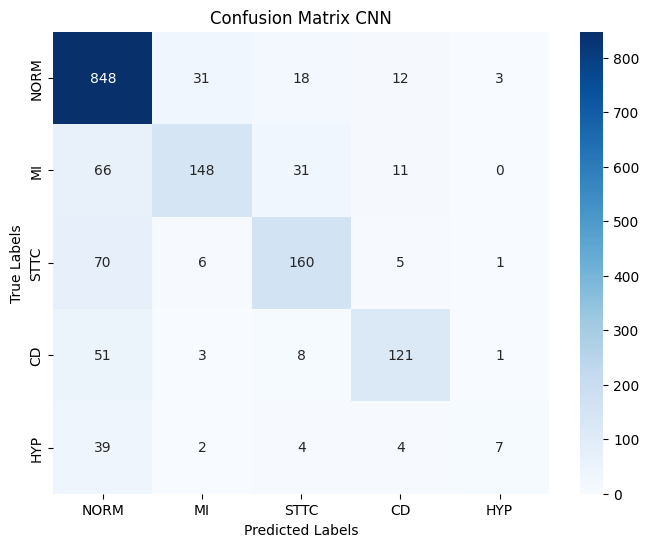

In [ ]:
metrics(y_test, y_test_predict, CLASS_NAMES)

In [ ]:
model_save_path = '/content/drive/MyDrive/dataset/models/'
model.save(model_save_path + 'ecg_lense.keras')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 128)      │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 250, 384)       │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 250, 384)       │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 250, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 125, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 125, 512)       │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 125, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 125, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,356,305 (20.43 MB)

 Trainable params: 1,784,581 (6.81 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 3,569,164 (13.62 MB)

In [ ]:
# input_shape = (1000, 12)
# best_kernel = 3
# best_units = 256
# best_batch_size = 64
# best_epochs = 50
# best_learning_rate = 0.001
# model1 = ecg_lense(input_shape=input_shape, kernel_size=best_kernel, dense_units=best_units)

# model1.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
#     loss='categorical_crossentropy',
#     metrics=['accuracy', keras.metrics.AUC(name='auc')]
# )

In [ ]:
# model.summary()

In [ ]:
# history = model1.fit(
#     X_train, y_train,
#     epochs=best_epochs,
#     batch_size=best_batch_size,
#     validation_split=0.15
# )

In [ ]:
# model_save_path = '/content/drive/MyDrive/dataset/models/'
# model.save(model_save_path + 'ecg_lens.keras')

In [ ]:
# test_loss, test_acc, test_auc = model1.evaluate(X_test, y_test, verbose=0)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_acc * 100:.2f}%")
# print(f"Test AUC: {test_auc:.4f}")

In [ ]:
# y_test_predict = model.predict(X_test)

In [ ]:
# indices = np.argmax(y_test, axis=1)
# print(indices)
# indices1 = np.argmax(y_test_predict, axis=1)
# print(indices1)

In [ ]:
# print(f'Accuracy Score test : {accuracy_score(indices, indices1)}')
# print(f'F1-Score train : {f1_score(indices, indices1, average="macro")}')
# print(f'Precision Score test : {precision_score(indices, indices1, average="macro")}')
# print(f'Recall Score test : {recall_score(indices, indices1, average="macro")}')

In [ ]:
# classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
# print(classification_report(indices, indices1, target_names=classes))

In [ ]:
# cm = confusion_matrix(indices, indices1)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix CNN')
# plt.show()